## Clustering

This notebook guides you through a real RNA-seq study from the NCBI Gene Expression Omnibus (GEO): a time-course of Arabidopsis thaliana (Col-0) seedlings challenged with Pseudomonas syringae pv. tomato DC3000. We will open and sanity-check the transcriptome count matrix (genes × samples), review its conditions/time points, perform basic QC and normalization, and then use K-means to cluster genes based on their expression patterns. Along the way, we’ll use the elbow and silhouette methods to select K and visualize the resulting clusters.

What you’ll learn

Load and validate a GEO RNA-seq count matrix (dimensions, missing values, sample metadata).

Normalize counts and focus on high-variance genes for clustering.

Run PCA for quick exploration and apply K-means to cluster genes by expression dynamics.

Choose K using elbow and silhouette criteria and interpret clusters biologically.

Dataset
Time-course RNA-seq of Arabidopsis thaliana Col-0 seedlings infected with Pseudomonas syringae pv. tomato DC3000 (GEO, NCBI).

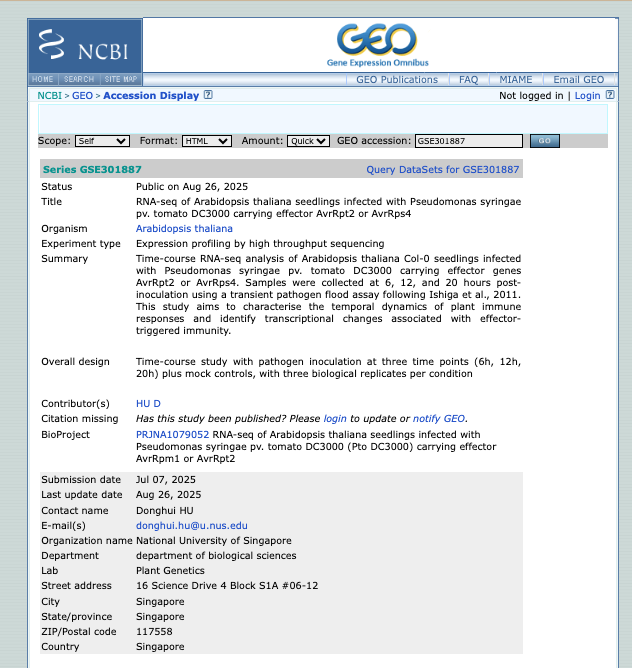

Load libraries

In [27]:
#get the data
!wget https://raw.githubusercontent.com/PlantHealth-Analytics/topics_ai/main/GSE301887_flood.raw.counts.txt

--2025-09-17 15:25:06--  https://raw.githubusercontent.com/PlantHealth-Analytics/topics_ai/main/GSE301887_flood.raw.counts.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3666795 (3.5M) [text/plain]
Saving to: ‘GSE301887_flood.raw.counts.txt.2’

GSE301887_flood.raw 100%[===================>]   3.50M  --.-KB/s    in 0.01s   

2025-09-17 15:25:06 (253 MB/s) - ‘GSE301887_flood.raw.counts.txt.2’ saved [3666795/3666795]



In [28]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

# --------------------
# Config
# --------------------
IN_PATH = "GSE301887_flood.raw.counts.txt"   # change path after uploading
OUT_DIR = "rnaseq_pca_kmeans_outputs"
MIN_CPM = 2.0
MIN_SAMPLES = 3
TOP_Genes_PCA = 2000
TOP_Genes_KMEANS = 5000
K_RANGE = list(range(2, 11))      # for elbow (saved for reference)
K_FIXED = 6                       # <- chosen K
RANDOM_STATE = 42

os.makedirs(OUT_DIR, exist_ok=True)

In [29]:
# 1) Load raw counts
df = pd.read_csv(IN_PATH, sep="\t")
if df.columns[0].lower() != "gene_id":
    df = df.rename(columns={df.columns[0]: "gene_id"})
df = df.set_index("gene_id")
df = df.loc[df.sum(axis=1) > 0]  # drop all-zero genes

First, let’s perform pre-processing—cleaning and normalizing the RNA-seq counts. We will:

Filter low-count genes (keep genes expressed in ≥ m samples with counts ≥ c).

Handle NAs (drop genes with missing values or resolve them appropriately).

Normalize by library size (CPM/TPM) and apply a log1p transform (or per-gene Z-score) before PCA/K-means.

In [30]:
# 2) CPM normalization
lib_sizes = df.sum(axis=0).astype(float)
cpm = (df / lib_sizes) * 1e6

In [31]:
# Filter: CPM >= MIN_CPM in at least MIN_SAMPLES samples
keep = (cpm >= MIN_CPM).sum(axis=1) >= MIN_SAMPLES
cpm_filt = cpm.loc[keep]

In [32]:
# Log2(CPM+1)
log_cpm = np.log2(cpm_filt + 1)
log_cpm.to_csv(os.path.join(OUT_DIR, "normalized_log2cpm.csv"))

# DIMENSIONALITY REDUCTION - PCA

Our first algorithm is dimensionality reduction, using Principal Component Analysis (PCA). With thousands of genes measured across multiple conditions and time points, it’s hard to visualize patterns directly. PCA transforms the gene-level matrix into a small set of orthogonal components (PC1, PC2, …) that explain most of the variation across samples. By plotting samples in this reduced space, we can check whether biological conditions cluster together and whether the main axes align with factors like treatment or time. The next code cell computes PCA on the normalized counts and shows PC1 vs PC2 colored by condition.

Step-by-step (bullet style)

Why PCA? Too many genes to visualize directly → compress to a few components that retain most variance.

What it does: Finds new axes (PCs) as linear combinations of genes; PCs are orthogonal and ranked by explained variance.

What we’ll look for: Samples from the same condition/time should appear close together; separation along PC1/PC2 suggests strong treatment/time effects.

Next cell: Run PCA on the normalized matrix and plot PC1 vs PC2 (points = samples, color = condition).

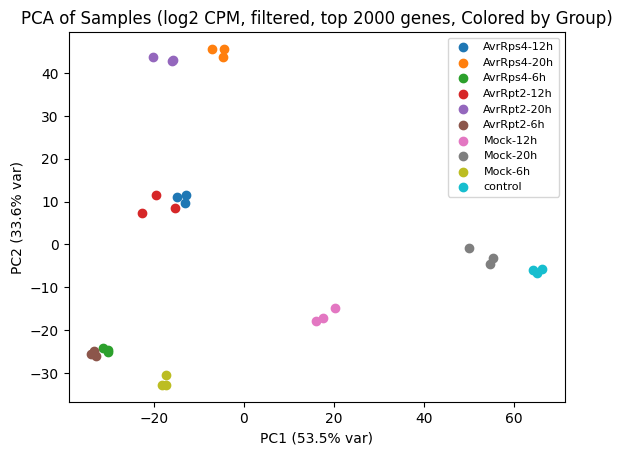

In [33]:
# 3) PCA on samples (top variable genes)
vars_ = log_cpm.var(axis=1).sort_values(ascending=False)
top_pca = vars_.index[:min(TOP_Genes_PCA, len(vars_))]
X = log_cpm.loc[top_pca].T  # samples x genes

scaler = StandardScaler(with_mean=True, with_std=True)
Xz = scaler.fit_transform(X)

pca_samples = PCA(n_components=2, svd_solver="randomized", random_state=RANDOM_STATE)
sample_pcs = pca_samples.fit_transform(Xz)

sample_pca_df = pd.DataFrame(sample_pcs, index=X.index, columns=["PC1","PC2"])
def parse_group(name):
    return name.split("_")[0] if "_" in name else (name.split("-")[0] if "-" in name else name)
sample_pca_df["group"] = [parse_group(s) for s in sample_pca_df.index]
sample_pca_df.to_csv(os.path.join(OUT_DIR, "pca_samples.csv"))

plt.figure()
for grp, sub in sample_pca_df.groupby("group"):
    plt.scatter(sub["PC1"], sub["PC2"], label=grp)
plt.xlabel(f"PC1 ({pca_samples.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_samples.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title(f"PCA of Samples (log2 CPM, filtered, top {len(top_pca)} genes, Colored by Group)")
plt.legend(loc="best", fontsize=8)
plt.savefig(os.path.join(OUT_DIR, "PCA_samples.png"), bbox_inches="tight")
plt.show()
plt.close()

Discuss!!!.....

# **CLUSTERING - KMEANS**

K-means gene clustering (unsupervised).
Now let’s go beyond comparing samples and instead group genes by their expression patterns across conditions/time points. This is an unsupervised task—no labels are provided—so we’ll use the K-means algorithm to discover genes that behave similarly. K-means partitions genes into K clusters by minimizing within-cluster variation, effectively grouping genes with correlated expression profiles. To choose a sensible K, we’ll first compute the elbow (and optionally silhouette) curves, then run K-means with the selected value and visualize the result (genes as points, colored by cluster).

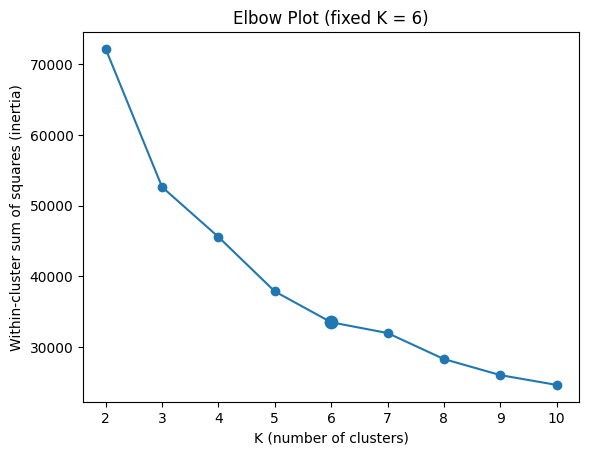

In [36]:
# 4) Elbow (for reference) + K-means on genes with fixed K
top_k = vars_.index[:min(TOP_Genes_KMEANS, len(vars_))]
G = log_cpm.loc[top_k].values  # genes x samples
Gz = StandardScaler(with_mean=True, with_std=True).fit_transform(G)  # z-score per gene

# Elbow curve (reference)
inertias = []
for k in K_RANGE:
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10, batch_size=2048)
    km.fit(Gz)
    inertias.append(km.inertia_)
pd.DataFrame({"K": K_RANGE, "inertia": inertias}).to_csv(
    os.path.join(OUT_DIR, "elbow_inertia.csv"), index=False
)

plt.figure()
plt.plot(K_RANGE, inertias, marker="o")
plt.xlabel("K (number of clusters)")
plt.ylabel("Within-cluster sum of squares (inertia)")
plt.title(f"Elbow Plot (fixed K = {K_FIXED})")
plt.scatter([K_FIXED], [inertias[K_RANGE.index(K_FIXED)] if K_FIXED in K_RANGE else np.nan], s=80)
plt.savefig(os.path.join(OUT_DIR, "Elbow_kmeans_genes.png"), bbox_inches="tight")
plt.show()
plt.close()

### Explaining the Elbow Plot

The plot above is the Elbow plot, a tool used to help select the optimal number of clusters (K) for K-means clustering.

*   **X-axis (K (number of clusters))**: Represents the different numbers of clusters attempted during the K-means analysis.
*   **Y-axis (Within-cluster sum of squares (inertia))**: Measures the sum of squared distances between each data point and its assigned cluster centroid. Lower inertia indicates tighter clusters.

The idea behind the Elbow method is to find the point on the curve where the rate of decrease in inertia sharply changes, resembling an "elbow." This point suggests that adding more clusters beyond this value does not significantly improve the clustering structure.

Looking at the plot, the decrease in inertia is substantial from K=2 up to around K=4 or K=5. After this point, the curve starts to flatten. The highlighted point at K=6 indicates the chosen number of clusters for the final K-means analysis in this notebook. While the "elbow" can be subjective, a value in the range of 4 to 6 appears to be a reasonable choice based on this plot.

In [35]:
import ipywidgets as widgets
from IPython.display import display

# Create a slider widget for K_FIXED
k_slider = widgets.IntSlider(
    value=K_FIXED, # Use the current K_FIXED value as the default
    min=K_RANGE[0], # Use the minimum from K_RANGE
    max=K_RANGE[-1], # Use the maximum from K_RANGE
    step=1,
    description='Select K:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

# Display the widget
display(k_slider)

IntSlider(value=6, continuous_update=False, description='Select K:', max=10, min=2)

Run K-means (with centroids) and visualize.
Now that we’ve chosen a reasonable K, we’ll fit K-means on the normalized gene × sample matrix. K-means represents each cluster by a centroid—the average expression profile of the genes in that cluster. The algorithm alternates between (1) assigning each gene to the nearest centroid and (2) updating centroids as the mean of their assigned genes, until assignments stabilize. We’ll then: (i) label every gene with its cluster, (ii) summarize cluster sizes, (iii) plot genes in 2D PCA space colored by cluster and overlay the centroids as larger markers, and (iv) export both the gene labels and the centroid profiles (mean expression per cluster) for downstream interpretation.

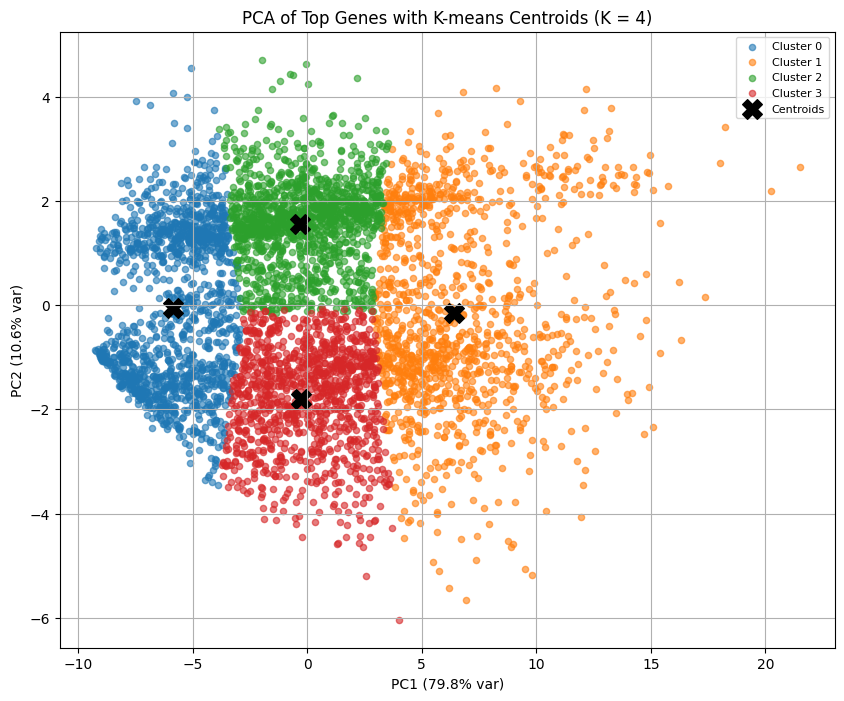

Done. Files written to: rnaseq_pca_kmeans_outputs


In [ ]:
# Final K-means with fixed K
# Use the value from the slider widget
selected_k = k_slider.value

kmeans = MiniBatchKMeans(n_clusters=selected_k, random_state=RANDOM_STATE, n_init=10, batch_size=2048)
labels = kmeans.fit_predict(Gz)
clusters = pd.DataFrame({"gene_id": log_cpm.loc[top_k].index, "cluster": labels})
clusters.to_csv(os.path.join(OUT_DIR, f"gene_kmeans_clusters_k{selected_k}.tsv"), sep="\t", index=False)

sizes = clusters["cluster"].value_counts().sort_index().rename_axis("cluster").reset_index(name="n_genes")
sizes.to_csv(os.path.join(OUT_DIR, f"cluster_sizes_k{selected_k}.tsv"), sep="\t", index=False)

# 5) Visualize genes as points (PCA)
pca_genes_model = PCA(n_components=2, svd_solver="randomized", random_state=RANDOM_STATE)
gene_pcs = pca_genes_model.fit_transform(Gz)

gene_pca_df = pd.DataFrame(gene_pcs, index=log_cpm.loc[top_k].index, columns=["PC1","PC2"])
gene_pca_df["cluster"] = labels

# Calculate the centroids in the PCA space
# We need to apply the same PCA transformation used for the genes to the K-means centroids
# First, get the centroids from the fitted KMeans model (these are in the original standardized gene space)
kmeans_centroids_original_space = kmeans.cluster_centers_

# Transform the centroids into the PCA space
kmeans_centroids_pca_space = pca_genes_model.transform(kmeans_centroids_original_space)

# Create a DataFrame for the centroids in PCA space
centroids_pca_df = pd.DataFrame(kmeans_centroids_pca_space, columns=["PC1", "PC2"])
centroids_pca_df["cluster"] = centroids_pca_df.index

# Plot the genes in PCA space, colored by cluster, and add the centroids
plt.figure(figsize=(10, 8))

# Plot the individual genes
for cluster_id, sub in gene_pca_df.groupby("cluster"):
    plt.scatter(sub["PC1"], sub["PC2"], label=f"Cluster {cluster_id}", alpha=0.6, s=20) # Smaller points for genes

# Plot the centroids
plt.scatter(centroids_pca_df["PC1"], centroids_pca_df["PC2"], marker="X", s=200, color="black", label="Centroids") # Larger 'X' for centroids

plt.xlabel(f"PC1 ({pca_genes_model.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca_genes_model.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title(f"PCA of Top Genes with K-means Centroids (K = {selected_k})")
plt.legend(loc="best", fontsize=8)
plt.grid(True)
plt.savefig(os.path.join(OUT_DIR, f"PCA_genes_kmeans_with_centroids_k{selected_k}.png"), bbox_inches="tight")
plt.show()


print("Done. Files written to:", OUT_DIR)

Try with different K. Discuss